In [1]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

In [2]:
mesh, softbody = data.get_xpbd_grape()

torch.Size([600, 3])
torch.Size([1200, 3])


In [3]:
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [0.000186, 0.008863, 0.002481],
                               [0.000208, 0.00664, 0.003521],
                               [0.000197, 0.004594, 0.004361],
                               [0.000208, 0.002349, 0.005903],
                               [0.000197, -0.00004, 0.006602],
                               [0.000208, -0.00204, 0.007502],
                               [0.000208, -0.00404, 0.008502]])

In [4]:
control_point = 31
target_point = 26

In [5]:
softbody.init_target_area(softbody.V[target_point], radius=1e-3)

target point connects to 7 vertices


In [6]:
softbody.target_list

[tensor([ 26,  27,  29,  30,  98, 539, 554], device='cuda:0')]

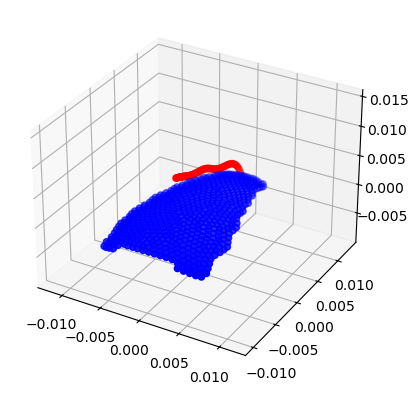

In [7]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
utils.axisEqual3D(ax)
# ax.view_init(elev=0, azim=0)
plt.show()

In [8]:
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)
softbody.fix_point(0, control_point)

cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [9]:
def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    # V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(V_boundary_stiffness_threshold - 1e-3)


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)

In [10]:
with torch.no_grad():
    for t in range(1, control_trajectory.shape[0]):
        softbody.V[control_point] = control_trajectory[t]

        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()

        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

        mesh.points = softbody.V.cpu().numpy()

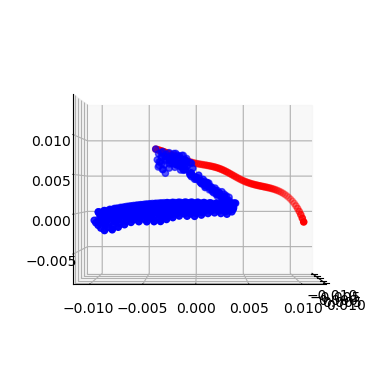

In [11]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
ax.scatter(control_trajectory[:, 0].cpu().numpy(), control_trajectory[:, 1].cpu().numpy(), control_trajectory[:, 2].cpu().numpy(), c='r', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

In [12]:
target_mesh = mesh.points.copy()
target_trajectory = control_trajectory.cpu().numpy().copy()

In [13]:
target_pos = softbody.V[softbody.target_list].clone()

In [14]:
target_pos

tensor([[ 2.0091e-04, -4.4762e-04,  5.1289e-03],
        [-1.5832e-04, -2.1686e-05,  4.6777e-03],
        [ 2.2274e-05, -1.5550e-03,  5.7053e-03],
        [ 3.7900e-04, -1.0292e-03,  5.7450e-03],
        [-4.7342e-04, -4.4618e-04,  5.0817e-03],
        [ 4.4491e-04,  3.1405e-04,  4.6345e-03],
        [ 7.4617e-04, -5.3732e-04,  5.2461e-03]], device='cuda:0')

In [44]:
mesh, softbody = data.get_xpbd_grape()
softbody.fix_point(0, control_point)
V_origin = softbody.V.clone()
Velocity_origin = softbody.V_velocity.clone()

KeyboardInterrupt: 

In [ ]:
softbody.init_target_area(softbody.V[target_point], radius=1e-3)

target point connects to 7 vertices


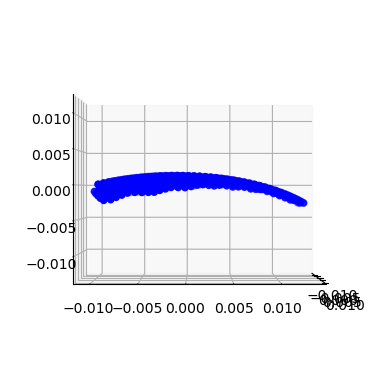

In [ ]:
# interpolate trajectory
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
# ax.scatter(mesh.points[control_list, 0], mesh.points[control_list, 1], mesh.points[control_list, 2], c='r', marker='o')
# ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='y', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)

In [ ]:
# Hardcoded control trajectory
cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [ ]:
def loss_fn(target, predict):
    return torch.norm(target - predict)

In [ ]:
u = torch.linspace(0, 1, 5).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[0.000224, 0.010794, -0.001233]])
start_point = torch.from_numpy(start_point).to(cfg.device)
spline_control = np.array([ [0.00021, 0.010, -0.001],
                            [0.00020, 0.009, 0.],
                            [0.00019, 0.008, 0.001],
                            [0.00018, 0.007, 0.002]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)
spline_control.requires_grad_(True)

tensor([[ 0.0002,  0.0100, -0.0010],
        [ 0.0002,  0.0090,  0.0000],
        [ 0.0002,  0.0080,  0.0010]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

In [ ]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [ ]:
def h_poly_helper(tt):
  A = torch.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def H_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = t
  for i in range(1, 4):
    tt[i] = tt[i-1]*t*i/(i+1)
  return h_poly_helper(tt)

def interp_func(x, y):
  "Returns integral of interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  def f(xs):
    if len(y)==1: # in the case of 1 point, treat as constant function
      return y[0] + torch.zeros_like(xs)
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = h_poly((xs-x[I])/dx)
    return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
  return f

def interp(x, y, xs):
  return interp_func(x,y)(xs)

def integ_func(x, y):
  "Returns interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
    Y = torch.zeros_like(y)
    Y[1:] = (x[1:]-x[:-1])*(
        (y[:-1]+y[1:])/2 + (m[:-1] - m[1:])*(x[1:]-x[:-1])/12
        )
    Y = Y.cumsum(0)
  def f(xs):
    if len(y)==1:
      return y[0]*(xs - x[0])
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = H_poly((xs-x[I])/dx)
    return Y[I] + dx*(
        hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
        )
  return f

def integ(x, y, xs):
  return integ_func(x,y)(xs)

In [ ]:
control = []
loss_list = []
spline_list = []
pre_loss = 100
for t in range(1000):
    print(t)
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline_x = interp(u, x_con, us)
    spline_y = interp(u, y_con, us)
    spline_z = interp(u, z_con, us)

    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    spline_list.append(spline_trajectory.detach().cpu().numpy())
    # reset for each test
    softbody.V = V_origin.clone()
    softbody.V_velocity = Velocity_origin.clone()

    cloth_dist_stiffness = 1
    V_boundary_stiffness = 0.1
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
    V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness
    
    for i in range(spline_trajectory.shape[0]):
        softbody.V[control_point] = spline_trajectory[i]
        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

    # interpolate trajectory
    
    loss = loss_fn(target_pos, V_ref[softbody.target_list])
    loss.backward()
    
    loss_list.append(loss.detach().cpu())
    print(loss)
    if loss.detach() < 0.001:
        break
    optimizer.step()
    optimizer.zero_grad()


    # mesh.points = softbody.V.cpu().numpy()

0
tensor(0.0267, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
1
tensor(0.0267, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
2
tensor(0.0257, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
3
tensor(0.0239, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
4
tensor(0.0205, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
5
tensor(0.0179, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
6
tensor(0.0157, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
7
tensor(0.0137, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
8
tensor(0.0119, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
9
tensor(0.0100, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
10
tensor(0.0082, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
11
tensor(0.0066, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
12
tensor(0.0053, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
13
tensor(0.0042, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
14

In [ ]:
spline_control

tensor([[ 0.0001,  0.0069,  0.0088],
        [ 0.0036,  0.0104,  0.0012],
        [-0.0003, -0.0052,  0.0088]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

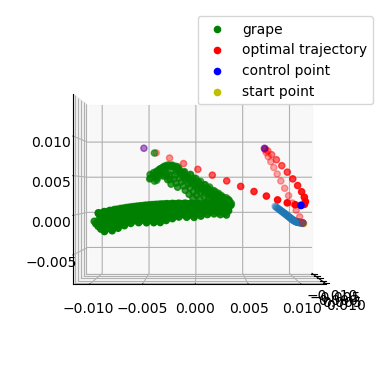

In [ ]:
# interpolate trajectory
control = np.array(control)
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='g', marker='o', label='grape')
ax.scatter(spline_trajectory[:, 0].cpu().detach(), spline_trajectory[:, 1].cpu().detach(), spline_trajectory[:, 2].cpu().detach(), c='r', marker='o', label='optimal trajectory')
ax.scatter(spline_control[:, 0].cpu().detach(), spline_control[:, 1].cpu().detach(), spline_control[:, 2].cpu().detach(), c='b', marker='o', label='control point')
ax.scatter(start_point[:, 0].cpu().detach(), start_point[:, 1].cpu().detach(), start_point[:, 2].cpu().detach(), c='y', marker='o', label='start point')
ax.scatter(spline_list[0][:, 0], spline_list[0][:, 1], spline_list[0][:, 2])
utils.axisEqual3D(ax)
# ax.view_init(elev=0, azim=0)
ax.legend()
plt.show()

In [ ]:
spline_mesh = mesh.points.copy()

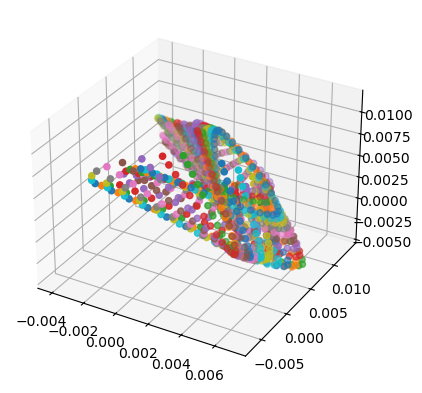

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
for i in spline_list:
    ax.scatter(i[:, 0], i[:, 1], i[:, 2], marker='o')

Text(0, 0.5, 'loss')

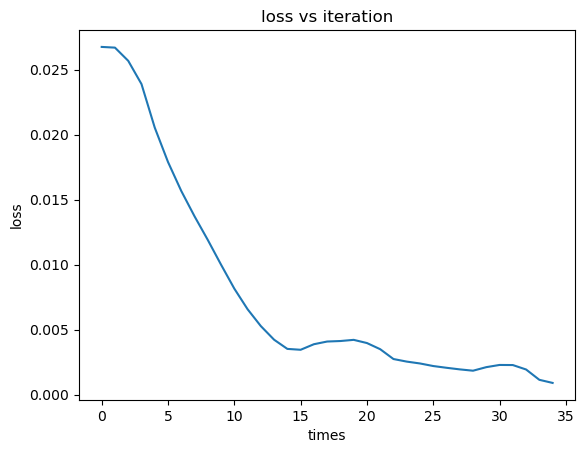

In [ ]:
plt.plot(loss_list)
plt.title('loss vs iteration')
plt.xlabel('times')
plt.ylabel('loss')

In [ ]:
mesh, softbody = data.get_xpbd_grape()
softbody.fix_point(0, control_point)
# Hardcoded control trajectory
cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

torch.Size([600, 3])
torch.Size([1200, 3])


In [ ]:
softbody.init_target_area(softbody.V[target_point], radius=1e-3)

target point connects to 7 vertices


In [ ]:
# init

for t in range(1, 20):
    softbody.V[control_point] = control_trajectory[t]

    step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=None,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=cfg.use_shape_matching,
                    use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()

    energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
    
    V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

    mesh.points = softbody.V.cpu().numpy()
    # pl.show(interactive_update=True)

In [ ]:
softbody.V.requires_grad_(True)
softbody.V_velocity.requires_grad_(True)

tensor([[-8.7311e-06,  1.7884e-05, -5.4017e-06],
        [-8.0443e-06,  1.4962e-05, -3.1781e-06],
        [-4.1677e-06,  1.5053e-05, -3.1549e-06],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0',
       requires_grad=True)

In [ ]:
control = []
loss_list = []
for t in range(1000):
    print(t)
    step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=None,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=cfg.use_shape_matching,
                    use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)

    ref_V_boundary_stiffness = V_boundary_stiffness[:cfg.n_surf].detach().clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    # print(torch.sigmoid(1e9 * (1e-8 - energy)))
    # V_boundary_stiffness[:cfg.n_surf][energy.squeeze() > 1e-8] = 1e-5
    V_boundary_stiffness[:cfg.n_surf] = ref_V_boundary_stiffness * torch.sigmoid(1e9 * (1e-8 - energy))

    loss = loss_fn(target_pos, V_ref[softbody.target_list])
    loss.backward()

    if loss > 5e-4:
        with torch.no_grad():
            V_ref[control_point] -= 0.002 * softbody.V.grad[control_point]
    else:
        control.append(V_ref[control_point].detach().cpu().numpy())
        softbody.V = V_ref.detach().clone().requires_grad_(True)
        softbody.V_velocity = V_velocity_ref.detach().clone().requires_grad_(True)
        break
    control.append(V_ref[control_point].detach().cpu().numpy())
    print('loss:', loss)
    loss_list.append(loss.detach().cpu().numpy())
    # print(softbody.V.grad[softbody.control_list])
    print(softbody.V.grad[control_point])
    softbody.V = V_ref.detach().clone().requires_grad_(True)
    softbody.V_velocity = V_velocity_ref.detach().clone().requires_grad_(True)

    
    # mesh.points = softbody.V.cpu().numpy()

0
loss: tensor(0.0264, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([-0.0300,  0.1619, -0.2841], device='cuda:0')
1
loss: tensor(0.0262, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([-0.0384,  0.2164, -0.3336], device='cuda:0')
2
loss: tensor(0.0257, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([-0.0338,  0.2880, -0.4084], device='cuda:0')
3
loss: tensor(0.0245, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([-0.0275,  0.4065, -0.4220], device='cuda:0')
4
loss: tensor(0.0235, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([-0.0160,  0.4801, -0.4029], device='cuda:0')
5
loss: tensor(0.0213, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([-0.0256,  0.7134, -0.4477], device='cuda:0')
6
loss: tensor(0.0190, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([-0.0337,  0.7413, -0.4032], device='cuda:0')
7
loss: tensor(0.0156, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([-0.01

KeyboardInterrupt: 

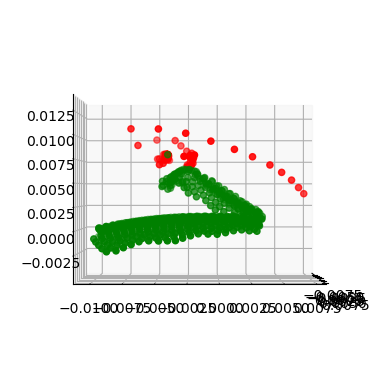

In [ ]:
# interpolate trajectory
control = np.array(control)
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='g', marker='o')
ax.scatter(control[:, 0], control[:, 1], control[:, 2], c='r', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

In [ ]:
point_mesh = mesh.points.copy()
point_trajectory = control.copy()

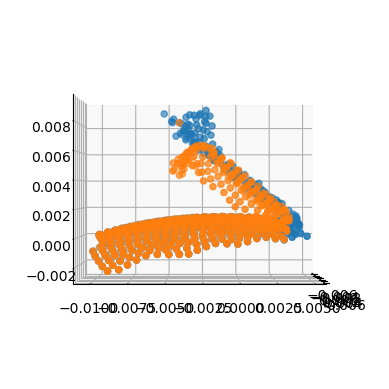

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(spline_mesh[:600, 0], spline_mesh[:600, 1], spline_mesh[:600, 2])
ax.scatter(point_mesh[:600, 0], point_mesh[:600, 1], point_mesh[:600, 2])
ax.view_init(elev=0, azim=0)